<a href="https://colab.research.google.com/github/yaraeslamm/foreground-detection-and-image-binarization/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Task Overview
# This code separates the foreground from the background in a video using a running average. For each frame, it calculates
# the absolute difference between the background model and the current frame, saving foreground images, mask images,
# and updated background models.

# Task Requirement
# Import OpenCV, read video files 'RuskaUfer25A.avi' and 'RuskaUfer25B.avi', convert frames to grayscale, and use a running average
# with a background update parameter β to distinguish the background from the foreground. Save output images in Google Drive.

import cv2
import numpy as np
import os
from google.colab import drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Set up paths for video files and output directories in Google Drive
video_files = ['/content/drive/My Drive/RuskaUfer25A.avi', '/content/drive/My Drive/RuskaUfer25B.avi']  # Update paths if necessary
output_base_dir = '/content/drive/My Drive/AVP/'

# Create output directories in Google Drive if they don’t exist
output_dirs = ['foreground_images', 'mask_images', 'background_images']
for dir_name in output_dirs:
    full_path = os.path.join(output_base_dir, dir_name)
    if not os.path.exists(full_path):
        os.makedirs(full_path)

# Parameters
beta = 0.05  # Adjust this value between 0 and 1 based on sensitivity requirements
frame_count = 0  # Frame counter for saving images

# Process each video file
for video_file in video_files:
    # Open the video
    cap = cv2.VideoCapture(video_file)
    ret, frame = cap.read()

    # If the video can't be read, skip
    if not ret:
        print(f"Error reading {video_file}")
        continue

    # Step 5: Initialize the background model using the first frame
    # Convert the first frame to grayscale for the background model
    bg_model = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype("float")

    # Process each frame
    while ret:
        # Convert current frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calculate the absolute difference between the current frame and the background model
        diff = cv2.absdiff(cv2.convertScaleAbs(bg_model), gray_frame)

        # Threshold the difference to get the foreground mask
        _, mask = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)

        # Extract the foreground by applying the mask to the original frame
        foreground = cv2.bitwise_and(frame, frame, mask=mask)

        # Update the background model using the running average formula
        cv2.accumulateWeighted(gray_frame, bg_model, beta)

        # Save the results to Google Drive
        cv2.imwrite(f"{output_base_dir}foreground_images/foreground_{frame_count:04d}.png", foreground)
        cv2.imwrite(f"{output_base_dir}mask_images/mask_{frame_count:04d}.png", mask)
        cv2.imwrite(f"{output_base_dir}background_images/background_{frame_count:04d}.png", cv2.convertScaleAbs(bg_model))

        # Read the next frame and increment the frame count
        ret, frame = cap.read()
        frame_count += 1

    # Release video capture for the current file
    cap.release()

print("Processing complete. Check Google Drive for results in 'video_processing_output' folder.")


Mounted at /content/drive
Processing complete. Check Google Drive for results in 'video_processing_output' folder.


Mounted at /content/drive


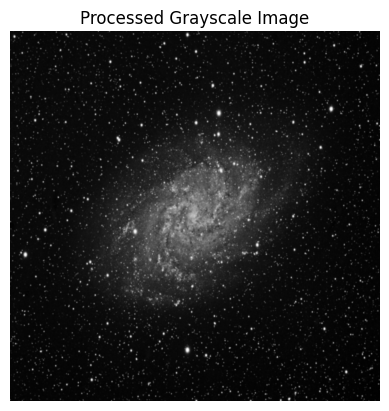

Converged after 11 iterations


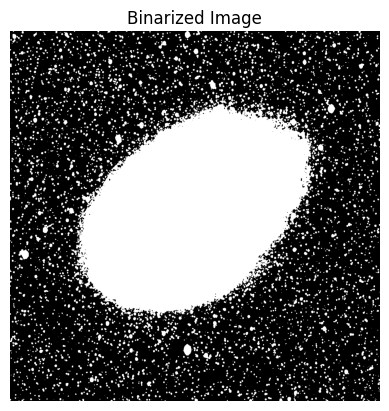

In [ ]:
#@ Task 2
# Task Overview
# This code implements an EM algorithm to binarize a galaxy image by distinguishing between background and foreground regions based on pixel intensity distributions.

# Task Requirement
# To preprocess the image and implement the ML estimator

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

# Replace 'path_to_your_image_in_drive' with the path where you uploaded your image in Google Drive
image_path = '/content/drive/My Drive/AVP/galaxy.jpg'

# Now, you can load the image from Google Drive as usual

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# Load and preprocess the image (adjust filename as necessary)
# image = cv2.imread('galaxycomp.jpg')
resized_image = cv2.resize(image, (1024, 1024), interpolation=cv2.INTER_AREA)
blurred_image = cv2.GaussianBlur(resized_image, (5, 5), 0)

# Display the preprocessed image
plt.imshow(blurred_image, cmap='gray')
plt.axis('off')
plt.title('Processed Grayscale Image')
plt.show()

# Step 3: Initialize EM Algorithm Parameters
tolerance = 1e-4  # Stopping criterion epsilon
max_iterations = 100
mu1, sigma1 = 50, 20  # Initial mean and variance for background (class 1)
mu2, sigma2 = 200, 30  # Initial mean and variance for foreground (class 2)

# Step 4: DistributionAssignment function
def DistributionAssignment(x, mu1, sigma1, mu2, sigma2):
    # Calculate probability density for background and foreground
    p1 = (1 / (np.sqrt(2 * np.pi * sigma1**2))) * np.exp(-((x - mu1)**2) / (2 * sigma1**2))
    p2 = (1 / (np.sqrt(2 * np.pi * sigma2**2))) * np.exp(-((x - mu2)**2) / (2 * sigma2**2))

    # Assign class based on higher probability
    return 1 if p1 > p2 else 2

# Step 5: UpdateModel function
def UpdateModel(x, i, mu, sigma):
    # Update mean and variance based on assigned pixels
    if i == 1:  # Update background
        mu_new = np.mean(x)
        sigma_new = np.std(x)
    else:       # Update foreground
        mu_new = np.mean(x)
        sigma_new = np.std(x)
    return mu_new, sigma_new

# Step 6: StopHere function
def StopHere(mu_old, sigma_old, mu_new, sigma_new):
    # Check if the change in mean and variance is below the tolerance level
    return abs(mu_old - mu_new) < tolerance and abs(sigma_old - sigma_new) < tolerance

# Step 7: EM Algorithm Execution
def EM_Binarization(image):
    global mu1, sigma1, mu2, sigma2
    for iteration in range(max_iterations):
        background_pixels = []
        foreground_pixels = []

        # Step 7a: Distribution assignment step for each pixel
        for pixel in image.flatten():  # Iterate through each pixel
            k = DistributionAssignment(pixel, mu1, sigma1, mu2, sigma2)
            if k == 1:
                background_pixels.append(pixel)
            else:
                foreground_pixels.append(pixel)

        # Step 7b: Model update step
        mu1_new, sigma1_new = UpdateModel(background_pixels, 1, mu1, sigma1)
        mu2_new, sigma2_new = UpdateModel(foreground_pixels, 2, mu2, sigma2)

        # Step 7c: Check for convergence
        if StopHere(mu1, sigma1, mu1_new, sigma1_new) and StopHere(mu2, sigma2, mu2_new, sigma2_new):
            print(f'Converged after {iteration + 1} iterations')
            break

        # Update parameters for the next iteration
        mu1, sigma1 = mu1_new, sigma1_new
        mu2, sigma2 = mu2_new, sigma2_new
    else:
        print('Reached maximum iterations without full convergence')

    # Step 7d: Final classification to binarize the image
    binary_image = np.array([[255 if DistributionAssignment(pixel, mu1, sigma1, mu2, sigma2) == 2 else 0
                              for pixel in row] for row in image])

    return binary_image

# Run the EM algorithm on the preprocessed image
binary_image = EM_Binarization(blurred_image)

# Display the final binarized image
plt.imshow(binary_image, cmap='gray')
plt.axis('off')
plt.title('Binarized Image')
plt.show()
